In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
valid_pred = "Organized_Outputs/3_Level2_Data/ConvLSTM_Dims/ConvTimeAwareLSTM/valid_prediction0.1 (4).npy"
valid_true = "Organized_Outputs/3_Level2_Data/ConvLSTM_Dims/ConvTimeAwareLSTM/valid_truth0.1 (4).npy"
train_pred = "Organized_Outputs/3_Level2_Data/ConvLSTM_Dims/ConvTimeAwareLSTM/train_prediction0.1 (4).npy"
train_true = "Organized_Outputs/3_Level2_Data/ConvLSTM_Dims/ConvTimeAwareLSTM/train_truth0.1 (4).npy"

# Examining validation set

In [3]:
preds = np.load(valid_pred)
true = np.load(valid_true)
preds.shape, true.shape

((240, 1, 1, 96, 96), (240, 1, 1, 96, 96))

# Validation set range of values

In [4]:
preds.max()

35.403572

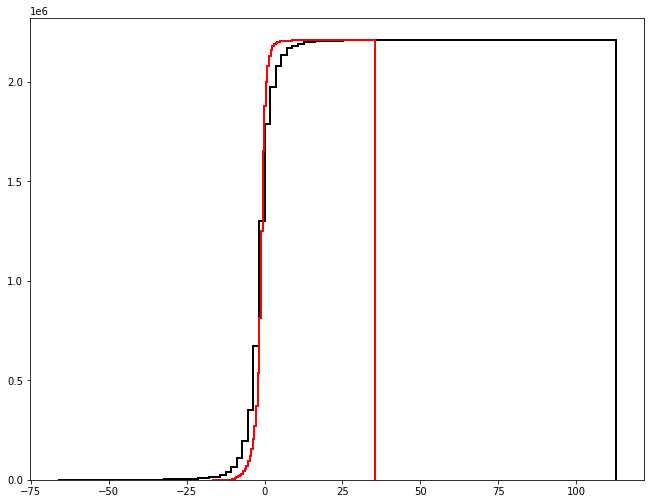

In [5]:
plt.figure(figsize = (11, 8.5))
a = plt.hist(true.flatten(), bins = 100,
         histtype = 'step', linestyle = '-',
         linewidth = 2, color = 'black', cumulative = True)
b = plt.hist(preds.flatten(), bins = 100,
         histtype = 'step', cumulative = True,
         linewidth = 2, color = 'red')

# View some of the validation set images

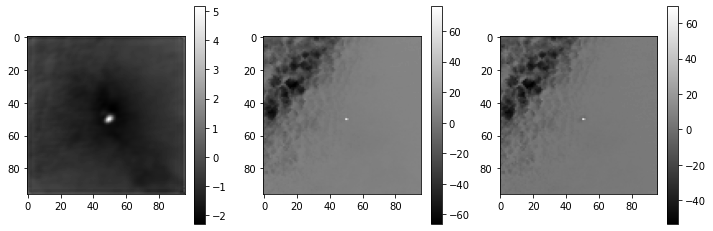

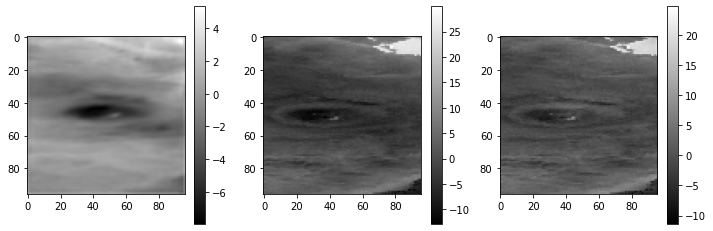

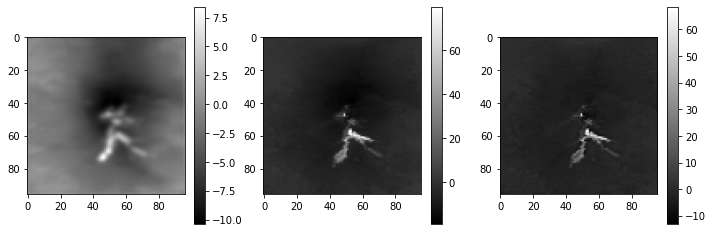

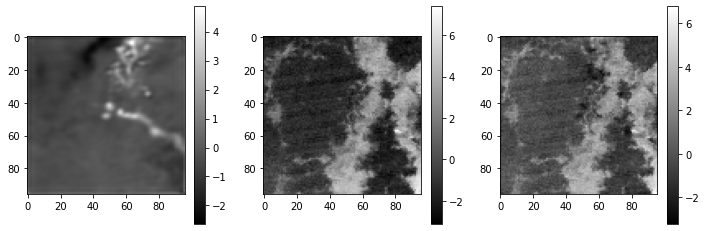

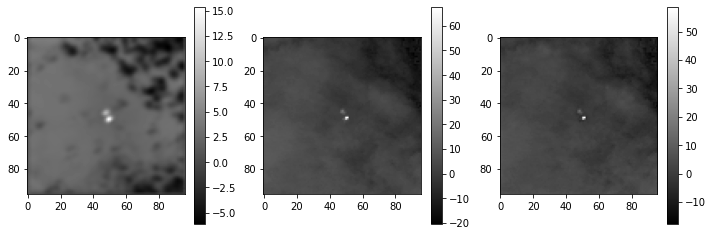

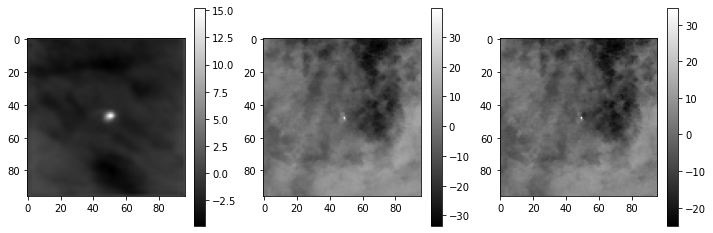

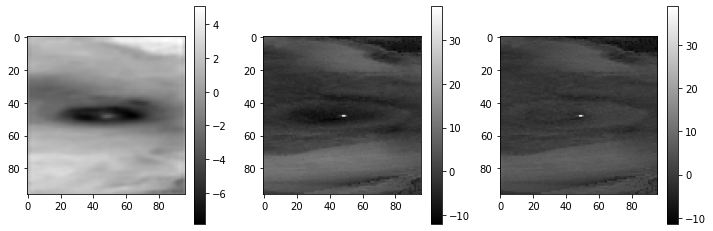

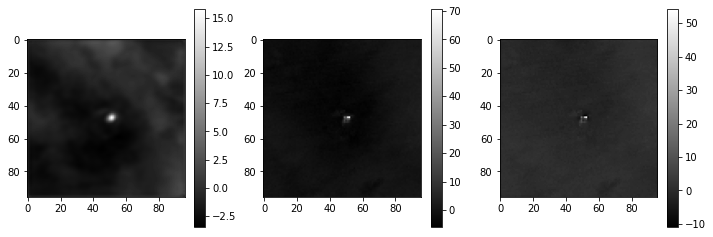

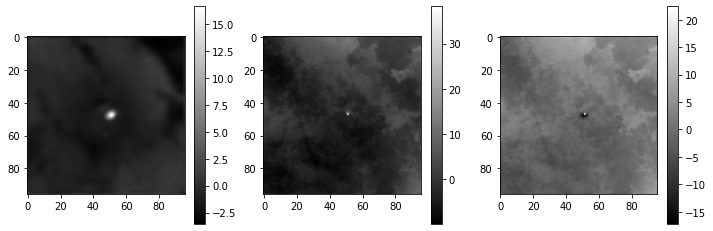

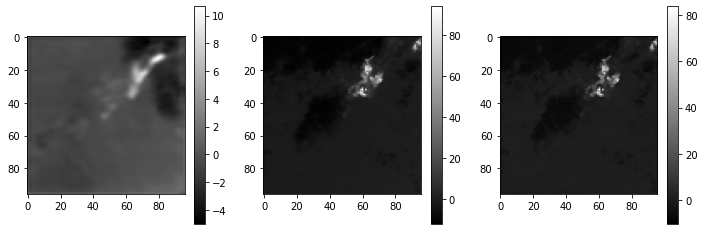

In [6]:
for i in range(10):
    i = np.random.choice(len(preds))
    f, axarr = plt.subplots(1,3)
    f.set_figheight(4)
    f.set_figwidth(12)
    a = axarr[0].imshow(preds[i, 0, 0, :, :], cmap = 'gist_gray')
    f.colorbar(a, ax=axarr[0])
    b = axarr[1].imshow(true[i, 0, 0, :, :], cmap = 'gist_gray')
    f.colorbar(b, ax=axarr[1])
    c = axarr[2].imshow(true[i, 0, 0, :, :] - preds[i+1, 0, 0, :, :], cmap = 'gist_gray')
    f.colorbar(c, ax=axarr[2])

# Summary metrics - RMSE and SSIM

In [7]:
np.sqrt(np.sum((true - preds)**2) / len(true.flatten()))

4.18137356741788

In [8]:
from skimage.metrics import structural_similarity as ssim

In [9]:
ssim_sk_ls = []
for i in range(preds.shape[0]):
    ssim_sk_ls.append(ssim(preds[i, 0, 0], true[i, 0, 0]))

In [10]:
np.mean(ssim_sk_ls)

0.08728783956169198

# Deriving some volcanology info - max Temperature

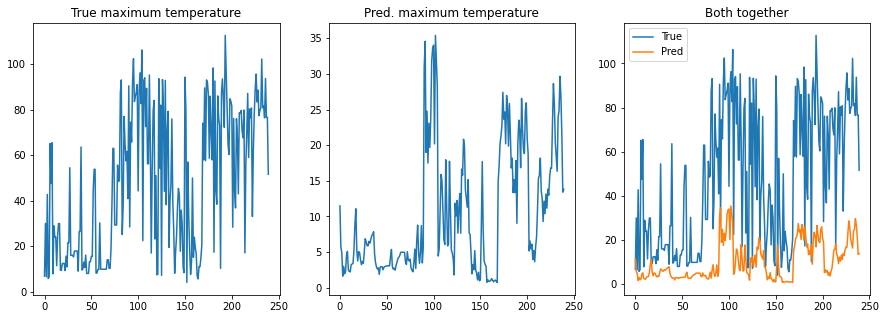

In [11]:
# Maximum temperature - true
max_T_ls = []
for i in range(len(true)):
    max_T_ls.append(np.max(true[i]))
# Maximum temperature - predicted    
max_T_ls2 = []
for i in range(len(preds)):
    max_T_ls2.append(np.max(preds[i]))
    
f, axarr = plt.subplots(1,3)
f.set_figheight(5)
f.set_figwidth(15)
axarr[0].plot(max_T_ls)
axarr[0].set_title('True maximum temperature')
axarr[1].plot(max_T_ls2)
axarr[1].set_title('Pred. maximum temperature')
axarr[2].plot(max_T_ls, label = 'True')
axarr[2].plot(max_T_ls2, label = 'Pred')
axarr[2].legend()
axarr[2].set_title('Both together');

In [12]:
max_T_ls = np.asarray(max_T_ls)
max_T_ls2 = np.asarray(max_T_ls2)
np.sqrt(np.sum((max_T_ls - max_T_ls2)**2) / len(max_T_ls))

46.05166086852895

# Number of hotspots (>10, >20, >35) and distance from summit

In [13]:
def get_num_hotspots_and_distance_from_summit(observed_imgs, pred_imgs, hot):
    
    # Assign each pixel a value corresp. to distance from the summit/center
    distance_from_summit = np.zeros((96, 96))
    for i in range(distance_from_summit.shape[0]):
        for j in range(distance_from_summit.shape[1]):
            distance_from_summit[i, j] = 90*np.sqrt((i-48)**2 + (j-48)**2)
            
    # Empty lists to store number of hotspots and furtherest hotspot from summit
    # for observed and predicted images
    distance_from_summit_ls = []
    num_hotspots_ls = []
    distance_from_summit_ls_pred = []
    num_hotspots_ls_pred = []
    # Binary indications of exceedance
    over = (observed_imgs >= hot).astype(int)
    over_pred = (pred_imgs >= hot).astype(int)
    
    # For each image
    for i in range(len(observed_imgs)):
        # Count the number of exceeding pixels
        num_hotspots_ls.append(np.sum(over[i, 0, 0]))
        num_hotspots_ls_pred.append(np.sum(over_pred[i, 0, 0]))
        # Find the distance of the furthest hotspot from the summit
        over[i, 0, 0] = over[i, 0, 0]*distance_from_summit
        distance_from_summit_ls.append(over[i, 0, 0].max())
        over_pred[i, 0, 0] = over_pred[i, 0, 0]*distance_from_summit
        distance_from_summit_ls_pred.append(over_pred[i, 0, 0].max())
        
    # Plot
    f, axarr = plt.subplots(1,2)
    f.set_figheight(4)
    f.set_figwidth(12)
    axarr[0].plot(num_hotspots_ls, label = 'True')
    axarr[0].plot(num_hotspots_ls_pred, label = 'Pred')
    axarr[0].legend()
    axarr[0].set_title('Number of hotspots\nhot >= ' + str(hot))
    axarr[1].plot(distance_from_summit_ls, label = 'True')
    axarr[1].plot(distance_from_summit_ls_pred, label = 'Pred')
    axarr[1].legend()
    axarr[1].set_title('Distance of furthest hotspot from summit\nhot >= ' + str(hot))
    
    num_hotspots_ls = np.asarray(num_hotspots_ls)
    num_hotspots_ls_pred = np.asarray(num_hotspots_ls_pred)
    distance_from_summit_ls = np.asarray(distance_from_summit_ls)
    distance_from_summit_ls_pred = np.asarray(distance_from_summit_ls_pred)
    print("Metrics for hotspot >=", hot)
    print("\tRMSE for number of hotspots:\n\t\t",
          np.sqrt(np.sum((num_hotspots_ls - num_hotspots_ls_pred)**2) / len(num_hotspots_ls)))
    print("\tRMSE for distance of furthest hotspot from summit:\n\t\t",
          np.sqrt(np.sum((distance_from_summit_ls - distance_from_summit_ls_pred)**2) / len(distance_from_summit_ls)),
         '\n')

Metrics for hotspot >= 10
	RMSE for number of hotspots:
		 567.652200588823
	RMSE for distance of furthest hotspot from summit:
		 2757.753376845 

Metrics for hotspot >= 20
	RMSE for number of hotspots:
		 51.24069021132847
	RMSE for distance of furthest hotspot from summit:
		 1759.3030414532532 

Metrics for hotspot >= 35
	RMSE for number of hotspots:
		 25.36713753395654
	RMSE for distance of furthest hotspot from summit:
		 1511.6404541093757 



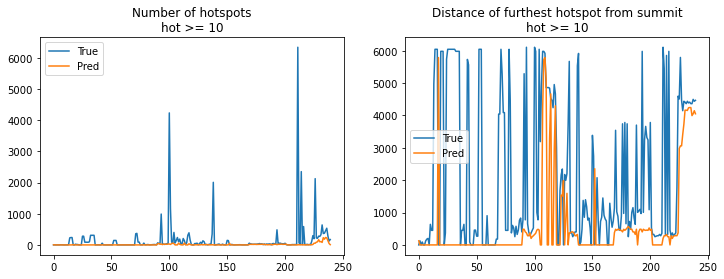

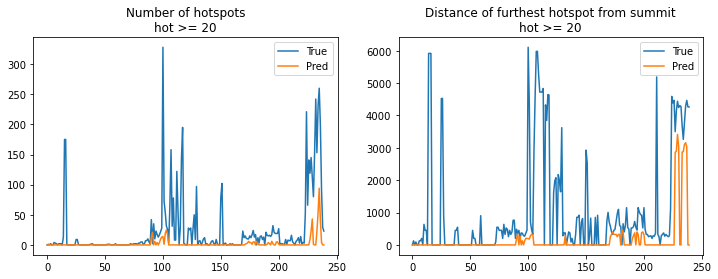

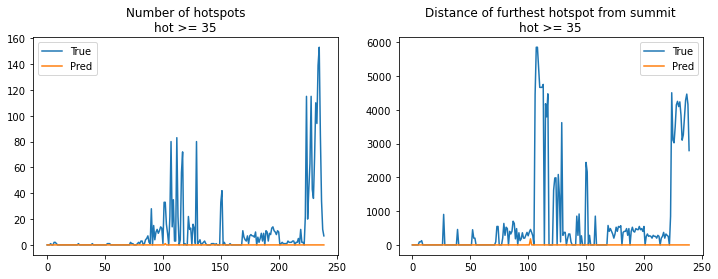

In [14]:
get_num_hotspots_and_distance_from_summit(true, preds, 10)
get_num_hotspots_and_distance_from_summit(true, preds, 20)
get_num_hotspots_and_distance_from_summit(true, preds, 35)

# Analysis recreated with post-processed data

In [15]:
template = np.load(train_true)
template.shape

(1127, 1, 1, 96, 96)

In [16]:
# Taken from source code of scikit-image's histogram_matching.py
# Match histogram of predicted validation set images to observed training observations
pred_values, pred_unique_indices, pred_counts = np.unique(preds.ravel(),
                                                          return_inverse=True,
                                                          return_counts=True)
tmpl_values, tmpl_counts = np.unique(template.ravel(), return_counts=True)
pred_quantiles = np.cumsum(pred_counts) / preds.size
tmpl_quantiles = np.cumsum(tmpl_counts) / template.size
interp_a_values = np.interp(pred_quantiles, tmpl_quantiles, tmpl_values)
out = interp_a_values[pred_unique_indices].reshape(preds.shape)

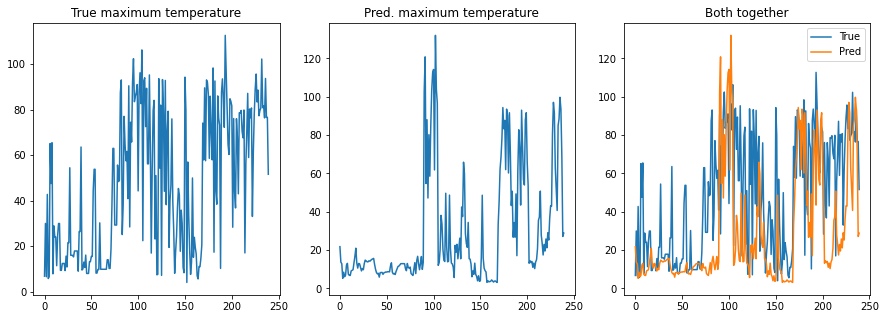

In [17]:
# Maximum temperature - true
max_T_ls = []
for i in range(len(true)):
    max_T_ls.append(np.max(true[i]))
# Maximum temperature - predicted    
max_T_ls2 = []
for i in range(len(out)):
    max_T_ls2.append(np.max(out[i]))
    
f, axarr = plt.subplots(1,3)
f.set_figheight(5)
f.set_figwidth(15)
axarr[0].plot(max_T_ls)
axarr[0].set_title('True maximum temperature')
axarr[1].plot(max_T_ls2)
axarr[1].set_title('Pred. maximum temperature')
axarr[2].plot(max_T_ls, label = 'True')
axarr[2].plot(max_T_ls2, label = 'Pred')
axarr[2].legend()
axarr[2].set_title('Both together');

In [18]:
max_T_ls = np.asarray(max_T_ls)
max_T_ls2 = np.asarray(max_T_ls2)
np.sqrt(np.sum((max_T_ls - max_T_ls2)**2) / len(max_T_ls))

34.138799470176465

Metrics for hotspot >= 10
	RMSE for number of hotspots:
		 562.9665990684231
	RMSE for distance of furthest hotspot from summit:
		 2515.3383470221256 

Metrics for hotspot >= 20
	RMSE for number of hotspots:
		 40.69326316070839
	RMSE for distance of furthest hotspot from summit:
		 1440.2682591563744 

Metrics for hotspot >= 35
	RMSE for number of hotspots:
		 18.032262753187688
	RMSE for distance of furthest hotspot from summit:
		 1119.7188616642422 



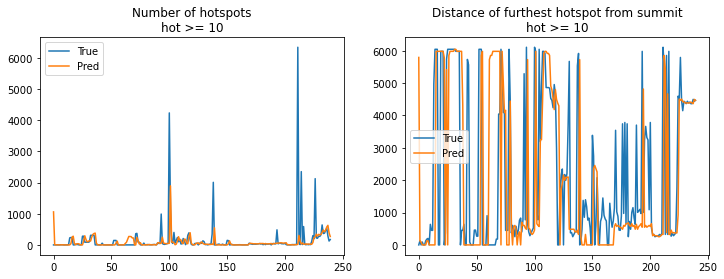

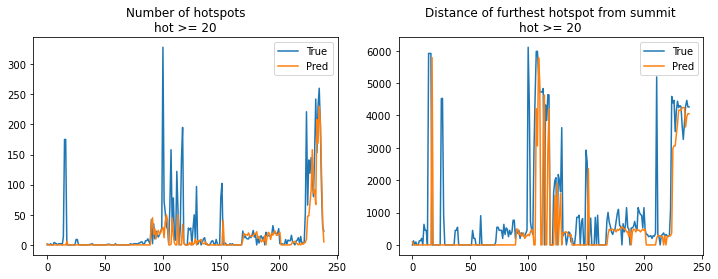

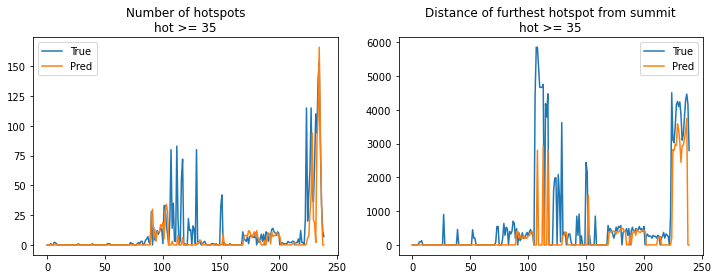

In [19]:
get_num_hotspots_and_distance_from_summit(true, out, 10)
get_num_hotspots_and_distance_from_summit(true, out, 20)
get_num_hotspots_and_distance_from_summit(true, out, 35)